In [1]:
import or_gym
from or_gym import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ray
from ray import tune
from ray.rllib import agents
import os
import pickle
import re

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def extract_plot_stats(path):
    window = 100
    ep_stats = ['hist_stats/episode_reward']
    train_data = pd.read_csv(path + '/progress.csv')
    for i in ep_stats:
        vals = None
        ep_vals = train_data[i].values
        for j in ep_vals:
            ep_vals = np.array(re.findall(r"[-+]?\d*\.\d+|\d+", j)).astype(float)
            if vals is None:
                vals = ep_vals.copy()
            else:
                vals = np.hstack([vals, ep_vals.copy()])

    reward_var = np.array([np.std(vals[i-window:i+1]) 
                           if i>window else np.std(vals[:i+1]) 
                           for i, j in enumerate(vals)])
    med_reward = np.array([np.median(vals[i-window:i+1]) 
                           if i>window else np.median(vals[:i+1]) 
                           for i, j in enumerate(vals)])
    ep_max = np.array([np.max(vals[i-window:i+1]) 
                           if i>window else np.max(vals[:i+1]) 
                           for i, j in enumerate(vals)])
    ep_min = np.array([np.min(vals[i-window:i+1]) 
                           if i>window else np.min(vals[:i+1]) 
                           for i, j in enumerate(vals)])
    mean_vals = np.array([np.mean(vals[i-window:i+1]) 
                           if i>window else np.mean(vals[:i+1]) 
                           for i, j in enumerate(vals)])
    fill_max = mean_vals + reward_var
    fill_min = mean_vals - reward_var
        
    data_dict = {'mean_rewards': mean_vals, 
                 'med_rewards': med_reward,
                 'std_rewards': reward_var,
                 'ep_min': ep_min, 
                 'ep_max': ep_max, 
                 'fill_max': fill_max, 
                 'fill_min': fill_min}
    return pd.DataFrame(data_dict), train_data

In [3]:
ray.init(ignore_reinit_error=True)
def load_policy(path, checkpoint_id="500", pickle_file=True):
    if pickle_file:
        with open(f"{path}/params.pkl", "rb") as read_file:
            config = pickle.load(read_file)
    else:
        with open(f"{path}/params.json", "r") as read_file:
            config = json.load(read_file)
    split_path = path.split('/')
    algo = 'ppo'
#     algo = [j for i, j in enumerate(split_path) if split_path[i-1] == 'ray_results'][0].lower()
    if hasattr(agents, algo):
        agent = getattr(agents, algo)
    
    trainer = getattr(agent, algo.upper() + 'Trainer')(config, env=utils.create_env(config['env']))
    trainer.restore(f"{path}/checkpoint_{checkpoint_id}/checkpoint-{checkpoint_id}")
    return trainer

2020-11-19 18:49:08,903	INFO services.py:1164 -- View the Ray dashboard at http://127.0.0.1:8265


In [4]:
env_name = 'InvManagement-v2'
ray_path = '../rl_models/v2'
# ray_path = '/home/cdhubbs/or-gym/rl_models/v2' # VM
iv2_paths = [p for p in os.listdir(ray_path) if env_name in p]
iv2_paths

plt.figure()
paths = []
max_rewards = []
for p in iv2_paths:
    d_path = os.path.join(ray_path, p)
    files = os.listdir(d_path)
    if 'error.txt' in files:
        continue
    try:
        data = pd.read_csv(os.path.join(d_path, 'progress.csv'))
        paths.append(d_path)
        max_rewards.append(data['episode_reward_mean'].max())
    except pd.errors.EmptyDataError:
        continue
    
    plt.plot(data['episode_reward_mean'])

plt.ylabel('Rewards')
plt.xlabel('Iterations')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../rl_models/v2/PPO_InvManagement-v2_62207_00005_5_lr=1e-06,vf_loss_coeff=0.5_2020-11-14_18-14-23/progress.csv'

<Figure size 432x288 with 0 Axes>

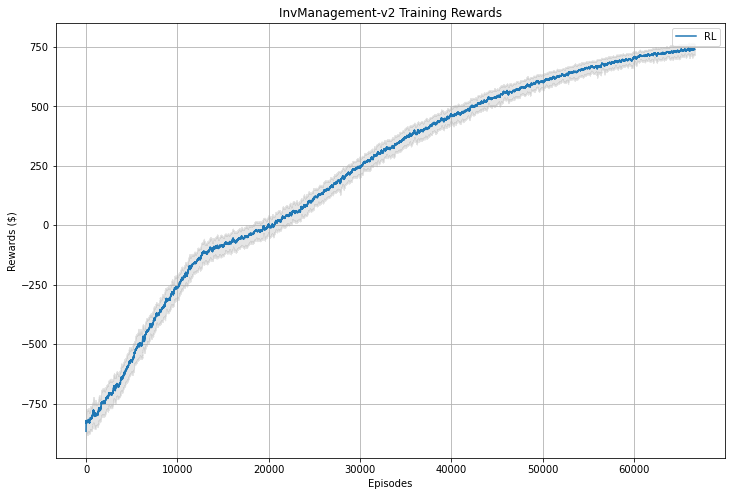

In [6]:
inv2_data, inv2_train_data = extract_plot_stats(paths[np.argmax(max_rewards)])
# Get episode totals
# x_min = -1000
x_max = inv2_data.shape[0]
opt_mean = 547
opt_var = 30
heur_mean = 388
heur_var = 30

plt.figure(figsize=(12,8))
plt.plot(inv2_data['mean_rewards'], label='RL')
plt.fill_between(np.arange(x_max), inv2_data['fill_min'], inv2_data['fill_max'],
                 color='gray', alpha=0.2)

# plt.axhline(xmin=0, xmax=x_max, y=heur_mean, color='r', label='Mean Base-Stock MIP Reward')
# plt.fill_between(np.arange(x_min, x_max), heur_mean-heur_var, 
#                  heur_mean+heur_var, color='r', alpha=0.2)

# plt.axhline(xmin=0, xmax=x_max, y=opt_mean, color='orange', label='Mean PIMILP Reward')
# plt.fill_between(np.arange(x_min, x_max), opt_mean-opt_var, 
#                  opt_mean+opt_var, color='orange', alpha=0.2)

plt.title('InvManagement-v2 Training Rewards')
# plt.legend(bbox_to_anchor=[1.45, 0.75])
plt.legend()
plt.xlabel('Episodes')
# plt.xlim([x_min, x_max])
plt.grid()
plt.ylabel('Rewards ($)')
plt.show()

## Load Trained Policy

We can benchmark our training rewards against a standardized set of scenarios to get a better idea for how our model performs vs our competing methods.

In [29]:
p = '../rl_models/v2/PPO_InvManagement-v2_62207_00005_5_lr=1e-06,vf_loss_coeff=0.5_2020-11-14_18-14-23'

In [30]:
# Load scenarios and policy
scenarios = pickle.load(open('../scenarios/data/inv2.pkl', 'rb'))
# trainer = load_policy(paths[np.argmax(max_rewards)])
trainer = load_policy(p)

(pid=15694) WARNING:tensorflow:From /home/christian/anaconda3/envs/or-gym-dev/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=15694) Instructions for updating:
(pid=15694) non-resource variables are not supported in the long term
(pid=15683) WARNING:tensorflow:From /home/christian/anaconda3/envs/or-gym-dev/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=15683) Instructions for updating:
(pid=15683) non-resource variables are not supported in the long term
2020-11-19 20:15:38,521	WARNING util.py:39 -- Install gputil for GPU system monitoring.
2020-11-19 20:15:38,650	INFO trainable.py:481 -- Restored on 192.168.1.105 from checkpoint: ../rl_models/v2/PPO_InvManagement-v2_62207_00005_5_lr=

In [31]:
env_name = 'InvManagement-v2'
base_path = '../scenarios/RL_v2'
env = or_gym.make(env_name)
inv2_test_data = {}
S0, S1 = [], []
Rewards = []
Actions = []
for i, d in enumerate(scenarios.T):
    s0 = env.reset()
    env.graph.edges[(1,0)]['user_D'] = [i for i in d]
    state0, state1 = [], []
    actions, rewards = [], []
    while True:
        action = trainer.compute_action(s0)
        s1, r, d, _ = env.step(action)
        s0 = s1.copy()
        state0.append(s0)
        state1.append(s1)
        actions.append(action)
        rewards.append(r)
        s0 = s1.copy()
        if d:
            S0.append(state0)
            S1.append(state1)
            Rewards.append(rewards)
            Actions.append(actions)
            break
        
        # Save env as a pickle file
        pickle.dump(env, open(base_path + f'/run{i}.pkl', 'wb'))
            
    if (i+1) % 10 == 0:
        print("Episode = {}\tRewards = {:.2f}".format(i+1, sum(rewards)))
        
inv2_data_dict = dict(
    rewards=np.vstack(Rewards),
    states0=np.vstack(S0),
    states1=np.vstack(S1),
    actions=np.vstack(Actions)
)

Episode = 10	Rewards = 753.75
Episode = 20	Rewards = 735.44
Episode = 30	Rewards = 700.15
Episode = 40	Rewards = 756.48
Episode = 50	Rewards = 749.40
Episode = 60	Rewards = 754.33
Episode = 70	Rewards = 755.32
Episode = 80	Rewards = 725.56
Episode = 90	Rewards = 758.45
Episode = 100	Rewards = 730.98


In [16]:
_ = [print(k, v.shape) for k, v in inv2_data_dict.items()]

rewards (100, 30)
states0 (3000, 68)
states1 (3000, 68)
actions (3000, 11)


In [17]:
# Pickle data
pickle.dump(inv2_data_dict, open('../scenarios/results/inv2_RL.pkl', 'wb'))

In [18]:
os.listdir('../scenarios/results')

['inv2_RL.pkl']

# InvManagement-v3

Explore the training results from `InvManagement-v3`.

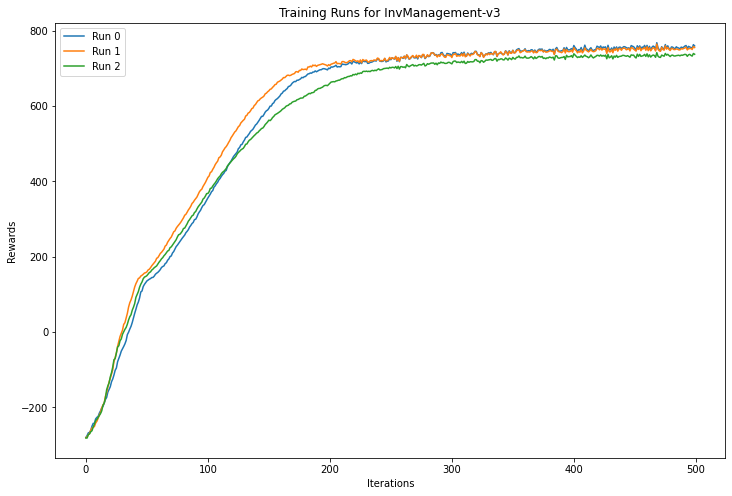

In [19]:
env_name = 'InvManagement-v3'
ray_path = '../rl_models/v3'
# ray_path = '/home/cdhubbs/or-gym/rl_models/v3' # VM
inv3_paths = [p for p in os.listdir(ray_path) if env_name in p]

plt.figure(figsize=(12,8))
paths = []
max_rewards = []
run_count = 0
for p in inv3_paths:
    d_path = os.path.join(ray_path, p)
    files = os.listdir(d_path)
    if 'error.txt' in files:
        continue
    try:
        data = pd.read_csv(os.path.join(d_path, 'progress.csv'))
        paths.append(d_path)
        max_rewards.append(data['episode_reward_mean'].max())
    except pd.errors.EmptyDataError:
        continue
    
    plt.plot(data['episode_reward_mean'], label=f'Run {run_count}')
    run_count += 1

plt.ylabel('Rewards')
plt.xlabel('Iterations')
plt.title('Training Runs for InvManagement-v3')
plt.legend()
plt.show()

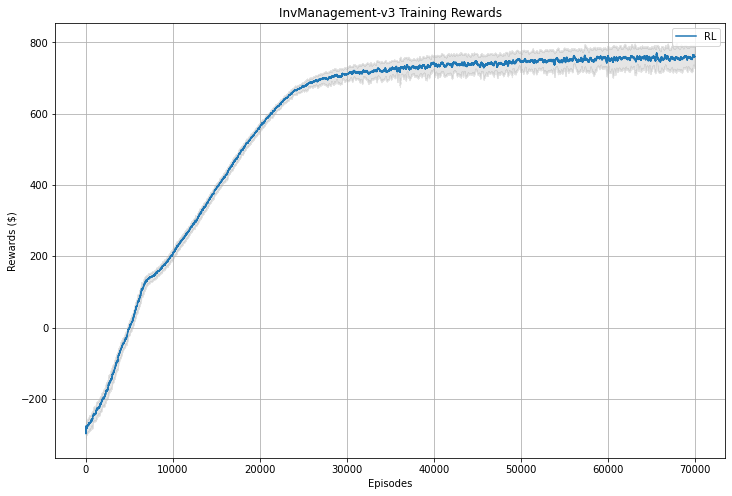

In [20]:
np.argmax(max_rewards)
inv3_data, inv3_train_data = extract_plot_stats(paths[np.argmax(max_rewards)])
# Get episode totals
# x_min = -1000
x_max = inv3_data.shape[0]
opt_mean = 547
opt_var = 30
heur_mean = 388
heur_var = 30


plt.figure(figsize=(12,8))
plt.plot(inv3_data['mean_rewards'], label='RL')
plt.fill_between(np.arange(x_max), inv3_data['fill_min'], inv3_data['fill_max'],
                 color='gray', alpha=0.2)

# plt.axhline(xmin=0, xmax=x_max, y=heur_mean, color='r', label='Mean Base-Stock MIP Reward')
# plt.fill_between(np.arange(x_min, x_max), heur_mean-heur_var, 
#                  heur_mean+heur_var, color='r', alpha=0.2)

# plt.axhline(xmin=0, xmax=x_max, y=opt_mean, color='orange', label='Mean PIMILP Reward')
# plt.fill_between(np.arange(x_min, x_max), opt_mean-opt_var, 
#                  opt_mean+opt_var, color='orange', alpha=0.2)

plt.title('InvManagement-v3 Training Rewards')
# plt.legend(bbox_to_anchor=[1.45, 0.75])
plt.legend()
plt.xlabel('Episodes')
# plt.xlim([x_min, x_max])
plt.grid()
plt.ylabel('Rewards ($)')
plt.show()

## Load Trained Policy

In [32]:
# Load scenarios and policy
scenarios = pickle.load(open('../scenarios/data/inv3.pkl', 'rb'))
# trainer = load_policy(paths[np.argmax(max_rewards)])
p = '../rl_models/v3/PPO_InvManagement-v3_15da5_00002_2_lr=1e-06,vf_loss_coeff=1.0_2020-11-15_23-50-05'
# p = '../rl_models/v3/PPO_InvManagement-v3_15da5_00005_5_lr=1e-06,vf_loss_coeff=0.5_2020-11-16_14-25-26'
# p = '../rl_models/v3/PPO_InvManagement-v3_15da5_00008_8_lr=1e-06,vf_loss_coeff=0.1_2020-11-17_01-38-48'
trainer = load_policy(p)

(pid=15681) WARNING:tensorflow:From /home/christian/anaconda3/envs/or-gym-dev/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=15681) Instructions for updating:
(pid=15681) non-resource variables are not supported in the long term
(pid=16347) WARNING:tensorflow:From /home/christian/anaconda3/envs/or-gym-dev/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=16347) Instructions for updating:
(pid=16347) non-resource variables are not supported in the long term
(pid=16348) WARNING:tensorflow:From /home/christian/anaconda3/envs/or-gym-dev/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated a

In [33]:
env_name = 'InvManagement-v3'
base_path = '../scenarios/RL_v3'
env = or_gym.make(env_name)
inv3_test_data = {}
S0, S1 = [], []
Rewards = []
Actions = []
for i, d in enumerate(scenarios.T):
    s0 = env.reset()
    env.graph.edges[(1,0)]['user_D'] = [i for i in d]
    state0, state1 = [], []
    actions, rewards = [], []
    while True:
        action = trainer.compute_action(s0)
        s1, r, d, _ = env.step(action)
        s0 = s1.copy()
        state0.append(s0)
        state1.append(s1)
        actions.append(action)
        rewards.append(r)
        s0 = s1.copy()
        if d:
            S0.append(state0)
            S1.append(state1)
            Rewards.append(rewards)
            Actions.append(actions)
            break
        
        # Save env as pickle file
        pickle.dump(env, open(base_path + f'/run{i}.pkl', 'wb'))

    if (i+1) % 10 == 0:
        print("Episode = {}\tRewards = {:.2f}".format(i+1, sum(rewards)))
        
inv3_data_dict = dict(
    rewards=np.vstack(Rewards),
    states0=np.vstack(S0),
    states1=np.vstack(S1),
    actions=np.vstack(Actions)
)

print(np.vstack(Rewards).sum(axis=1).mean())

Episode = 10	Rewards = 743.74
Episode = 20	Rewards = 717.18
Episode = 30	Rewards = 789.22
Episode = 40	Rewards = 745.43
Episode = 50	Rewards = 776.25
Episode = 60	Rewards = 790.91
Episode = 70	Rewards = 787.99
Episode = 80	Rewards = 754.27
Episode = 90	Rewards = 771.44
Episode = 100	Rewards = 719.61
757.0490300000002


In [19]:
np.vstack(Rewards).sum(axis=1).mean() 
# Run 1 = 757.6
# Run 2 = 753.0
# Run 3 = 

757.59329

In [ ]:
np.vstack(Rewards).sum(axis=1).mean() # Run 2

In [24]:
# Pickle data
pickle.dump(inv3_data_dict, open('../scenarios/results/inv3_RL.pkl', 'wb'))

In [25]:
inv3_data_dict['rewards'].sum(axis=1).mean()

757.79477